## Etude du son de la voix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import IPython.display

In [2]:
fe, data = scipy.io.wavfile.read('voiceP.wav')
length = data.shape[0] / fe
time = np.linspace(0., length, data.shape[0])

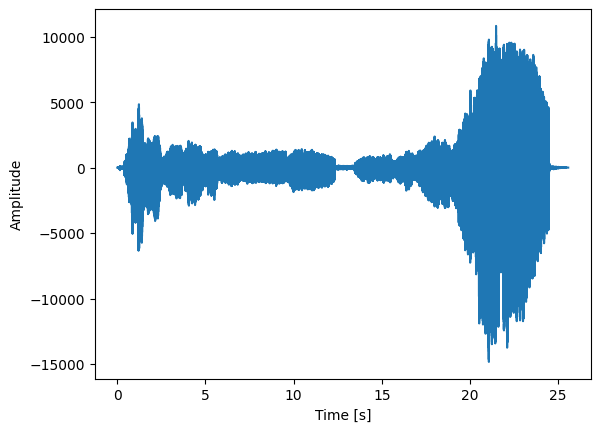

In [3]:
plt.plot(time, data, label="Flute signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
IPython.display.Audio(data, rate = fe)

In [4]:
T=0.04 # durée de stationnarité des signale sonores
N = round(T*fe)
t = np.array(range(-N+1,N-1))/fe

decalage = 0.01
ND = round(decalage*fe)

### Détection de $f_0$ avec la FFT

501.13636363636397

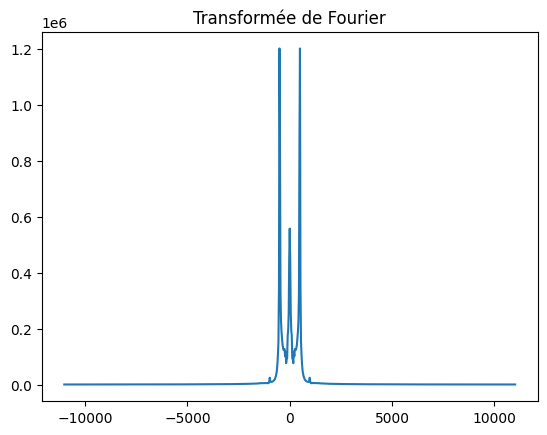

In [23]:
def calcul_freq_fft(indice_tram,plot_figure):

    x = data[1+int(indice_tram)*ND:N+int(indice_tram)*ND]
    window = scipy.signal.windows.barthann(51,sym=True)

    x = scipy.signal.convolve(x,window,mode='same')
    X = scipy.fft.fft(x)

    XP = scipy.fft.fftshift(np.abs(X))

    peaks, _ = scipy.signal.find_peaks(XP)
    sorted_peaks = sorted(XP[peaks])[::-1]
    
    freq = np.linspace(-fe/2,fe/2,len(XP))
    
    if plot_figure:
        plt.title("Transformée de Fourier")
        plt.plot(freq, XP)

    f0 = max(freq[np.argwhere(XP==max(XP))])[0]
    
    return f0

calcul_freq_fft(40,True)

In [24]:

def calcul_bonne_freq_fft():

    peaks_shape = []
    tram = [i for i in range(0,round(data.shape[0]/ND),40)]
    bonne_tram = []

    for indice_tram in tram:
        x = data[1+int(indice_tram)*ND:N+int(indice_tram)*ND]
        window = scipy.signal.windows.barthann(51,sym=True)

        x = scipy.signal.convolve(x,window,mode='same')
        X = scipy.fft.fft(x)

        XP = scipy.fft.fftshift(np.abs(X))

        XP_mean = XP[XP>XP.mean()]

        peaks, _ = scipy.signal.find_peaks(XP)
        sorted_peaks = sorted(XP[peaks])[::-1]

        freq = np.linspace(-fe/2,fe/2,len(XP))

        f0 = max(freq[np.argwhere(XP==max(XP))])[0]
        
        
        if sorted_peaks[0]>2*sorted_peaks[2] and f0>50:    
            bonne_tram.append(np.array([indice_tram,f0]))
        
    return np.array(bonne_tram)

bonne_tram = calcul_bonne_freq_fft()
pourcentage = len(bonne_tram)/len(range(0,round(data.shape[0]/ND),40))*100
print("Le pourcentage de bonnes trames est : {:.2f}%".format(pourcentage))

Le pourcentage de bonnes trames est : 67.69%


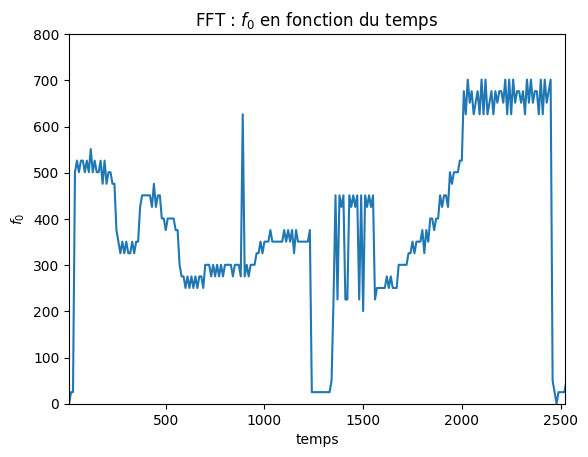

In [26]:
def trace_f0_fft_voix():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        f0 = calcul_freq_fft(indice_tram,False)
        f0_list.append(np.array([indice_tram,f0]))
    f0_list = np.array(f0_list)
    plt.ylim(0,800)
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.title("FFT : $f_0$ en fonction du temps")
    plt.xlabel('temps')
    plt.ylabel('$f_0$')
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.show()

trace_f0_fft_voix()

### Détection de $f_0$ avec l'autocorrélation

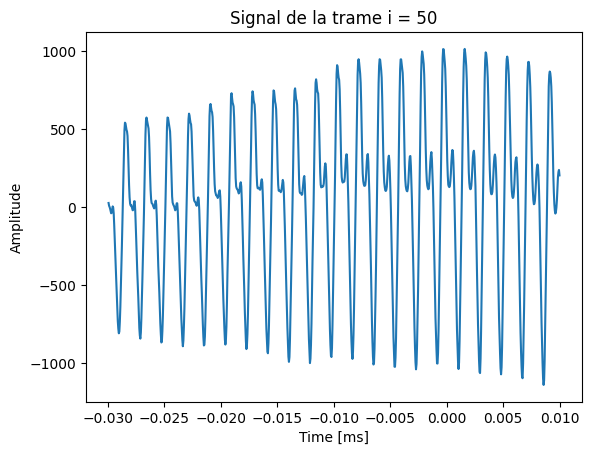

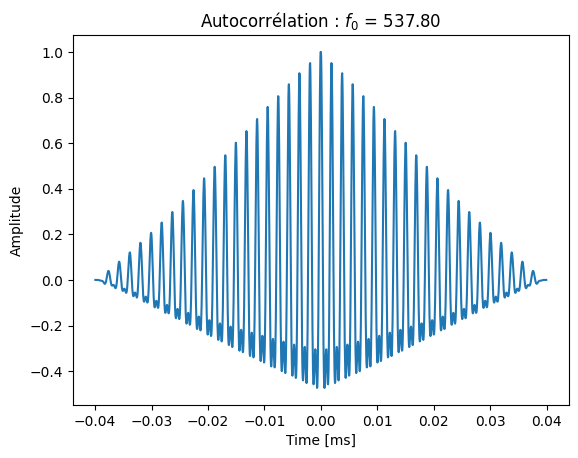

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


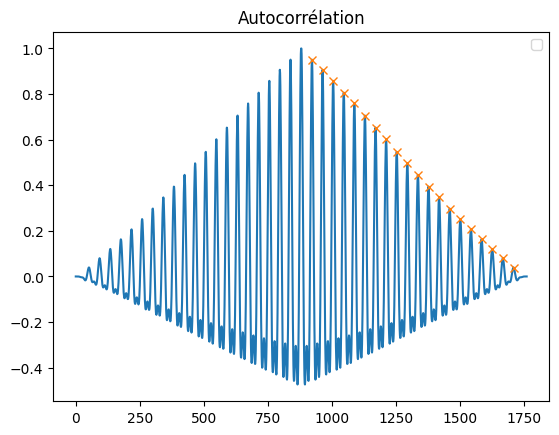

(0.0021261509461683956, 537.8048780487806)

In [8]:
def calcul_freq_xcor(indice_tram,plot_signal,plot_corr,plot_peaks):
    
    x = data[1+indice_tram*ND:N+indice_tram*ND]
    xcorr = sm.tsa.stattools.ccf(x,x,adjusted=False)
    xcorr = np.concatenate((xcorr[::-1],xcorr))

    
    try:
        peaks,_ =scipy.signal.find_peaks(xcorr)
        sorted_peaks = sorted(xcorr[peaks],reverse=True)

        t0 = t[:len(xcorr)]
        f0 = 1/t0[np.argwhere(xcorr == sorted_peaks[1])]
        f0 = f0[f0>0][0]
        
        peaks_positive = peaks[np.argwhere(t0[peaks]>=0)].flatten().tolist()
        peaks_positive.append(peaks[np.argwhere(xcorr[peaks]==max(xcorr))].flatten()[0])
        peaks_positive = np.array(peaks_positive)
        peaks_positive = peaks_positive[np.argwhere(xcorr[peaks_positive]>0)].flatten()
        
        
        points = np.array([(t0[i],xcorr[i]) for i in peaks_positive])
        
        # peaks_positive = np.array(peaks_positive)
        
        A0,Ainf = points[0],points[-1]
        vec_dir = A0-Ainf
        angles = []
        for i in range(1,len(points)-3):
            Ai = points[i]
            u,v = Ai-A0, Ai-Ainf
            angle_indice = np.arccos(np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)))
            angles.append(angle_indice)
        
        angle = max(angles) 
        
        if plot_signal:
            plt.plot(t[1+ND:N+ND], x)
            plt.xlabel("Time [ms]")
            plt.ylabel("Amplitude")
            plt.title(f'Signal de la trame i = {indice_tram}')
            plt.show()
        if plot_corr:
            plt.plot(t[:len(xcorr)], xcorr)
            plt.xlabel("Time [ms]")
            plt.ylabel("Amplitude")
            plt.title('Autocorrélation : $f_0$ = {:.2f}'.format(f0))
            plt.show()
        if plot_peaks:
            # plt.figure(figsize=(16,8))
            plt.plot(xcorr)
            # plt.plot(peaks_positive[:-1][0],xcorr[peaks_positive[:-1][0]],'x',label="$A_0$")
            # plt.plot(peaks_positive[:-1][5],xcorr[peaks_positive[:-1][5]],'x',label="$A_6$")
            # plt.plot(peaks_positive[:-1][-1],xcorr[peaks_positive[:-1][-1]],'x',label="$A_\inf$")
            plt.plot(peaks_positive[:-1],xcorr[peaks_positive[:-1]],'x')
            plt.title('Autocorrélation')
            plt.legend()
            plt.show()
        
        return angle,f0
    except:
        pass
    
    if plot_signal:
        plt.plot(t[1+ND:N+ND], x)
        plt.xlabel("Time [ms]")
        plt.ylabel("Amplitude")
        plt.title(f'Signal de la trame i = {indice_tram}')
        plt.show()

calcul_freq_xcor(50,True,True,True) 


In [9]:
def recherche_de_frequence_tout_le_signal_voix(seuil):
    tram_avec_bonne_freq = []
    for indice_tram in range(0,round(data.shape[0]/ND),40):
        try:
            angle,f0 = calcul_freq_xcor(indice_tram,False,False,False)
            # print(angle)
            if angle<seuil:
                tram_avec_bonne_freq.append((indice_tram,f0))
        except:
            pass
    
    return tram_avec_bonne_freq


In [10]:
tram_avec_bonne_freq = recherche_de_frequence_tout_le_signal_voix(seuil=0.5)
pourcentage = len(tram_avec_bonne_freq)/len(range(0,round(data.shape[0]/ND),40))*100
print("Le pourcentage de bonnes trames est : {:.2f}%".format(pourcentage))

Le pourcentage de bonnes trames est : 35.38%


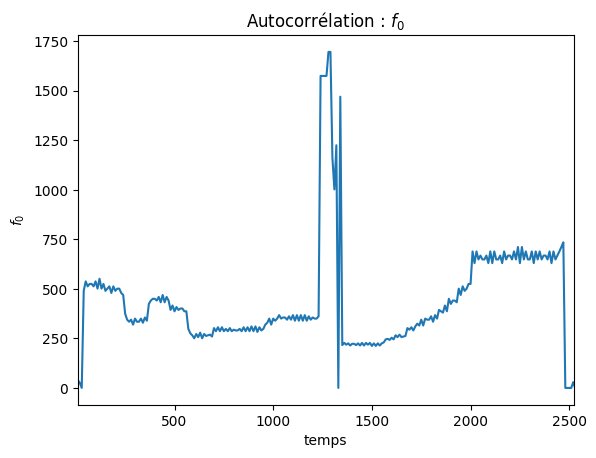

In [27]:
def trace_f0_xcor_voix():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        try:
            angle,f0 = calcul_freq_xcor(indice_tram,False,False,False)
            f0_list.append(np.array([indice_tram,f0]))
        except:
            f0_list.append(np.array([indice_tram,0]))
    f0_list = np.array(f0_list)
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.title("Autocorrélation : $f_0$")
    plt.xlabel('temps')
    plt.ylabel('$f_0$')
    plt.show()
    

trace_f0_xcor_voix()

### Détection de $f_0$ avec la méthode Burg

In [12]:
def calcul_DSP_burg(coef,sigma):
    
    term2=2j*np.pi/fe*np.arange(1,4+1)
    term2 = term2.reshape(4,1)
    freq = np.linspace(-fe/2,fe/2,fe)
    freq = freq.reshape(freq.shape[0],1)
    term3=term2@freq.T
    term=1.+coef@np.exp(term3)
    DSP = sigma/(term*np.conj(term))
    DSP = np.abs(DSP)
    return freq,DSP

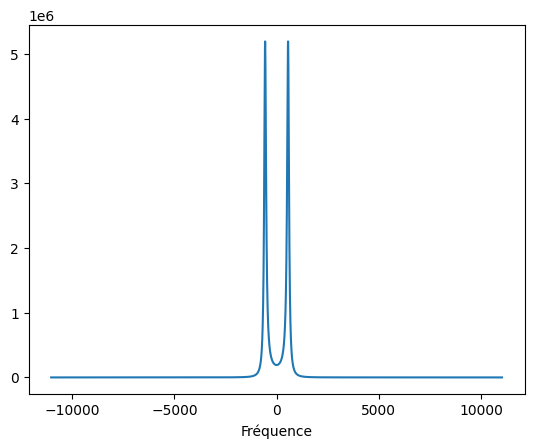

In [13]:
def calcul_freq_burg(indice_tram,plot_figure):
    
    x = data[1+indice_tram*ND:N+indice_tram*ND]
    
    window = scipy.signal.windows.bartlett(51)
    x_fen = scipy.signal.convolve(x,window,mode='same')


    rho, sigma2 = sm.regression.linear_model.burg(x,4)
    rho_fen, sigma2_fen = sm.regression.linear_model.burg(x_fen,4)
    
    rho = -rho
    rho_fen = -rho_fen

    freq, DSP = calcul_DSP_burg(rho,sigma2)
    freq_fen, DSP_fen = calcul_DSP_burg(rho_fen,sigma2_fen)
    
    peaks,_ = scipy.signal.find_peaks(DSP)

    f0 = abs(freq_fen[np.argwhere(DSP_fen==max(DSP_fen))].flatten()[0])    
    
    if plot_figure:
        plt.plot(freq,DSP)
        # plt.title("Densité Spectrale de Puissance : $f_0 = {:.3f}$".format(f0))
        plt.xlabel('Fréquence')
        plt.show()
 
    
    return f0


calcul_freq_burg(40,True)
sh = []

# for i in range(0,round(data.shape[0]/ND),10):
#     sh.append(calcul_freq_burg(i,False))

# plt.stem(sh)


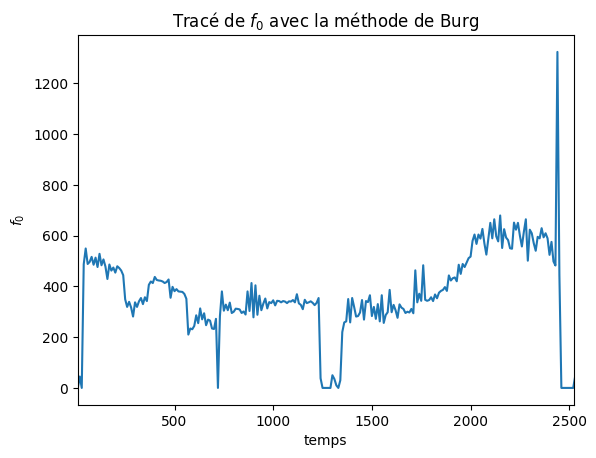

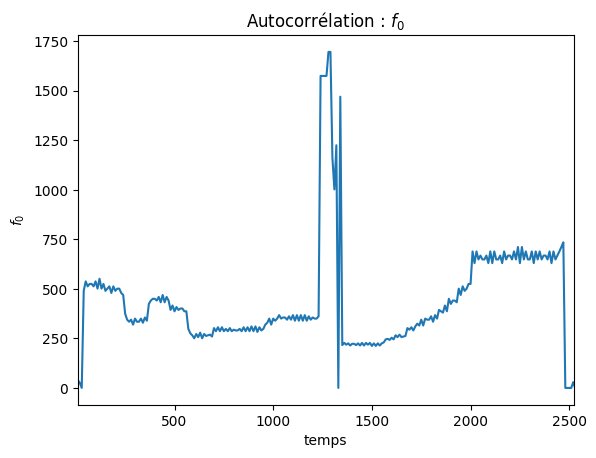

In [31]:
def trace_f0_burg_voix():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        f0 = calcul_freq_burg(indice_tram,False)
        f0_list.append(np.array([indice_tram,f0]))
    f0_list = np.array(f0_list)
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.title("Tracé de $f_0$ avec la méthode de Burg")
    plt.xlabel('temps')
    plt.ylabel('$f_0$')
    plt.show()
    

trace_f0_burg_voix()
trace_f0_xcor_voix()

In [30]:
def calcul_bonne_freq_burg():
    
    # Parametre a faire
    tram = [i for i in range(0,round(data.shape[0]/ND),40)]
    bonne_tram = []
    
    for indice_tram in tram:
    
        x = data[1+indice_tram*ND:N+indice_tram*ND]
        
        window = scipy.signal.windows.barthann(51)
        x_fen = scipy.signal.convolve(x,window,mode='same')

        rho_fen, sigma2_fen = sm.regression.linear_model.burg(x_fen,4)
        rho, sigma2 = sm.regression.linear_model.burg(x,4)
        rho_fen = -rho_fen

        freq_fen, DSP_fen = calcul_DSP_burg(rho_fen,sigma2_fen)
        freq, DSP = calcul_DSP_burg(rho,sigma2)
        
        f0 = abs(freq_fen[np.argwhere(DSP_fen==max(DSP_fen))].flatten()[0])
        
        peaks,_ = scipy.signal.find_peaks(DSP)
        if peaks.shape[0]>2:
            bonne_tram.append(np.array([indice_tram,f0]))
        
    bonne_tram = np.array(bonne_tram)
        
    print(bonne_tram.shape[0]/len(tram))
calcul_bonne_freq_burg()

0.16923076923076924
